In [2]:
import sys
sys.path.insert(0,'..')

%load_ext autoreload
%autoreload 2

In [4]:
import football_modelling.metrica.io as mio
import football_modelling.metrica.viz as mviz
import football_modelling.metrica.velocities as mvel
import football_modelling.metrica.pitchcontrol as mpc
from football_modelling.data import load_metrica_dir
import numpy as np


In [6]:
DATADIR = load_metrica_dir()
game_id = 2  # let's look at sample match 2


In [8]:
events = mio.read_event_data(DATADIR, game_id)

# read in tracking data
tracking_home = mio.tracking_data(DATADIR, game_id, "Home")
tracking_away = mio.tracking_data(DATADIR, game_id, "Away")

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home, tracking_away, events = mio.to_single_playing_direction(
    tracking_home, tracking_away, events
)

# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home, smoothing=True)
tracking_away = mvel.calc_player_velocities(tracking_away, smoothing=True)


Reading team: home
Reading team: away


In [9]:
# get all shots and goals in the match
shots = events[events["Type"] == "SHOT"]
goals = shots[shots["Subtype"].str.contains("-GOAL")].copy()

print(goals)


      Team  Type              Subtype  Period  Start Frame  Start Time [s]  \
198   Home  SHOT       ON TARGET-GOAL       1        12202          488.08   
823   Away  SHOT       ON TARGET-GOAL       1        53049         2121.96   
1118  Home  SHOT  HEAD-ON TARGET-GOAL       2        73983         2959.32   
1671  Away  SHOT       ON TARGET-GOAL       2       115009         4600.36   
1723  Home  SHOT       ON TARGET-GOAL       2       121027         4841.08   

      End Frame  End Time [s]      From   To  Start X  Start Y  End X  End Y  
198       12212        488.48  Player10  NaN   -47.70    -3.40 -54.06  -2.04  
823       53075       2123.00  Player24  NaN    44.52     2.72  54.06   1.36  
1118      73995       2959.80   Player9  NaN   -47.70     1.36 -54.06   2.04  
1671     115024       4600.96  Player20  NaN    40.28     1.36  55.12   2.72  
1723     121055       4842.20  Player12  NaN   -30.74     5.44 -54.06   2.72  


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

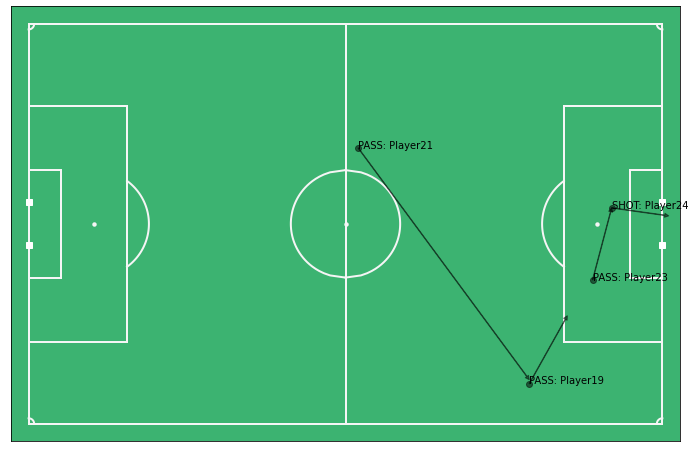

In [10]:
# plot the 3 events leading up to the second goal
mviz.plot_events(
    events.loc[820:823], color="k", indicators=["Marker", "Arrow"], annotate=True
)


In [12]:
# first get pitch control model parameters
params = mpc.default_model_params()
# find goalkeepers for offside calculation
GK_numbers = [mio.find_goalkeeper(tracking_home), mio.find_goalkeeper(tracking_away)]


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

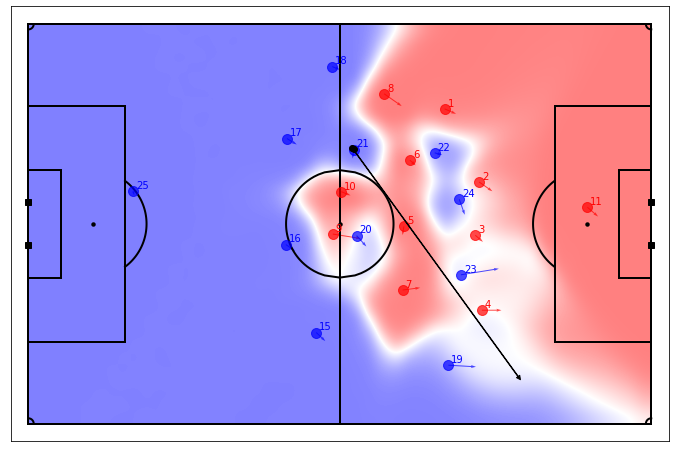

In [13]:
# evaluated pitch control surface for first pass
PPCF, xgrid, ygrid = mpc.generate_pitch_control_for_event(
    820,
    events,
    tracking_home,
    tracking_away,
    params,
    GK_numbers,
    field_dimen=(
        106.0,
        68.0,
    ),
    n_grid_cells_x=50,
)
mviz.plot_pitchcontrol_for_event(
    820, events, tracking_home, tracking_away, PPCF, annotate=True
)


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

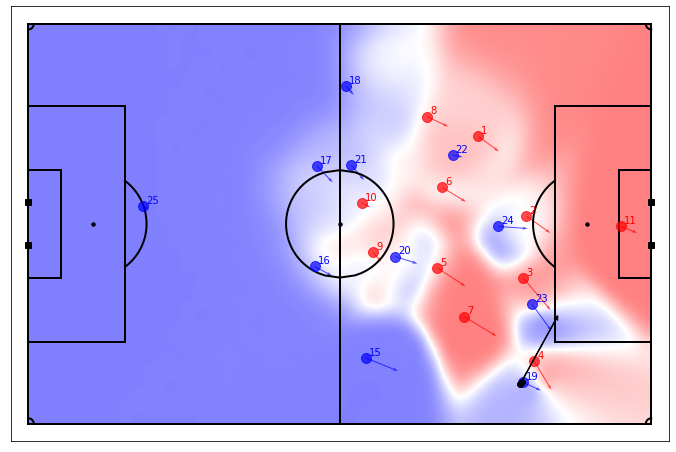

In [14]:
# evaluated pitch control surface for second pass
PPCF, xgrid, ygrid = mpc.generate_pitch_control_for_event(
    821,
    events,
    tracking_home,
    tracking_away,
    params,
    GK_numbers,
    field_dimen=(
        106.0,
        68.0,
    ),
    n_grid_cells_x=50,
)
mviz.plot_pitchcontrol_for_event(
    821, events, tracking_home, tracking_away, PPCF, annotate=True
)


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

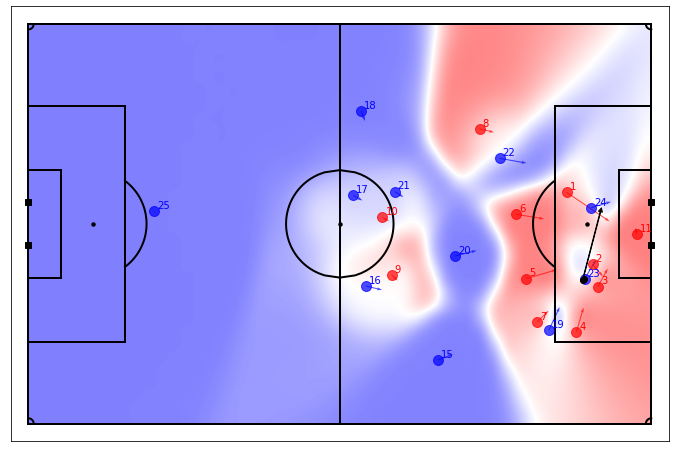

In [15]:
# evaluated pitch control surface for third pass
PPCF, xgrid, ygrid = mpc.generate_pitch_control_for_event(
    822,
    events,
    tracking_home,
    tracking_away,
    params,
    GK_numbers,
    field_dimen=(
        106.0,
        68.0,
    ),
    n_grid_cells_x=50,
)
mviz.plot_pitchcontrol_for_event(
    822, events, tracking_home, tracking_away, PPCF, annotate=True
)


In [16]:
""" **** calculate pass probability for every home team succesful pass **** """
# get all home passes
home_passes = events[(events["Type"].isin(["PASS"])) & (events["Team"] == "Home")]

# list for storing pass probablities
pass_success_probability = []

for i, row in home_passes.iterrows():
    pass_start_pos = np.array([row["Start X"], row["Start Y"]])
    pass_target_pos = np.array([row["End X"], row["End Y"]])
    pass_frame = row["Start Frame"]

    attacking_players = mpc.initialise_players(
        tracking_home.loc[pass_frame], "Home", params, GK_numbers[0]
    )
    defending_players = mpc.initialise_players(
        tracking_away.loc[pass_frame], "Away", params, GK_numbers[1]
    )
    Patt, Pdef = mpc.calculate_pitch_control_at_target(
        pass_target_pos, attacking_players, defending_players, pass_start_pos, params
    )

    pass_success_probability.append((i, Patt))


Text(0, 0.5, 'Frequency')

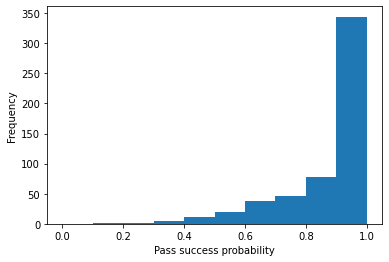

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist([p[1] for p in pass_success_probability], np.arange(0, 1.1, 0.1))
ax.set_xlabel("Pass success probability")
ax.set_ylabel("Frequency")


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

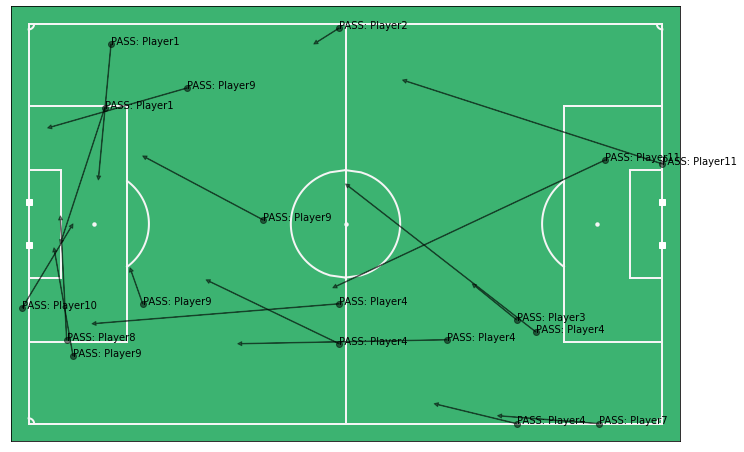

In [19]:
# sort the passes by pitch control probability
pass_success_probability = sorted(pass_success_probability, key=lambda x: x[1])

# identify the events corresponding to the most risky passes (pitch control < 0.5)
risky_passes = events.loc[[p[0] for p in pass_success_probability if p[1] < 0.5]]

# plot the events
mviz.plot_events(risky_passes, color="k", indicators=["Marker", "Arrow"], annotate=True)


In [20]:
# Print events that followed those risky passes
print("Event following a risky (completed) pass")
for p in pass_success_probability[:20]:
    outcome = events.loc[p[0] + 1].Type
    print(p[1], outcome)


Event following a risky (completed) pass
0.16032323299177256 BALL LOST
0.1613295457364337 CHALLENGE
0.21206157666402695 SHOT
0.31160841865474675 CHALLENGE
0.33190526185319935 SHOT
0.3370434729809066 CHALLENGE
0.3639283907689767 BALL LOST
0.4131562523163675 CHALLENGE
0.42042677463419303 PASS
0.431271262852387 CHALLENGE
0.44435098489184177 CHALLENGE
0.4484489555199406 PASS
0.45936651514837745 CHALLENGE
0.46181533356257215 SHOT
0.4680481708799845 CHALLENGE
0.48972755639125787 CHALLENGE
0.4900872646495709 CHALLENGE
0.4917205100922201 SHOT
0.5001349056944226 PASS
0.5026909720011076 PASS
